## CMEE MSC Project 2019
### Fitting distributions to honey bee foraging distance data
---

In [1]:
## Imports ##
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from scipy.special import gammainc
from scipy.special import erf
from scipy.optimize import minimize

In [9]:
## Functions ##
def aic_eq(ll, params):
    # Calculates AIC of given likelihood and parameter numbers.
    k = len(params)
    return -2 * ll + 2 * k

def inverse_cdf(data):
    # Produce the inverse CDF of 1-d data provided.
    sorted_data = -np.sort(-data)
    prob = np.arange(0, len(data), 1) / len(data)
    return pd.DataFrame({"SortedData":sorted_data, "Probability":prob})

# minimizing functions and CCDFs #
def ll_exp(lamb, x):
    # Likelihood function for exponential distribution
    eq = lamb * np.exp(-lamb * x)
    ll = (-1) * np.sum(np.log(eq))
    return ll

def exp_eq(lamb, x):
    # Equation for exponential distribution [CCDF]
    eq = 1-np.exp(-lamb * x)
    return 1-eq

def ll_gamma(params, x):
    # Likelihood function for gamma distribution
    shape, scale = params
    eq = (1/(gamma(shape) * scale**shape)) * x**(shape-1) * np.exp(-(x/scale))
    ll = (-1) * np.sum(np.log(eq))
    return ll

def gamma_eq(params, x):
    # Equation for gamma distribution [CCDF]
    alpha, beta = params
    eq = gammainc(alpha, x / beta)
    return 1 - eq

def ll_halfnorm(sigma, x):
    # Likelihood function for half-normal distribution
    eq = (np.sqrt(2)/(sigma * np.sqrt(np.pi))) * np.exp(-((x**2)/ (2 * sigma**2)))
    ll = (-1) * np.sum(np.log(eq))
    return ll

def halfnorm_eq(sigma, x):
    # Equation for half-normal distribution [CCDF]
    eq = erf(x/(sigma * np.sqrt(2)))
    return 1 - eq

def ll_lognorm(params, x):
    # Likelihood function for lognormal distribution
    mu, sigma = params
    eq = (1/(x * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(x) - mu)**2/(2 * sigma**2)))
    ll = (-1) * np.sum(np.log(eq))
    return ll

def lognorm_eq(params, x):
    # Equation for lognormal distribution [CCDF]
    mu, sigma = params
    eq = ((1 / 2) + (1 / 2) * erf((np.log(x) - mu) / 
              np.sqrt(2 * sigma)))
    return 1 - eq

def model_minimize(data, startest, fun):
    # Minimising function
    kwargs = {"method" : "SLSQP"}
    args = (fun, startest, data)
    model = minimize(*args, **kwargs)
    return mode

def predict(data, prest, fun):
    # Get predicted data from optimised model parameter values
    ivdata = inverse_cdf(data)
    lengths = np.linspace(max(data),
                          min(data),
                          num = len(data))
    prediction = fun(prest, lengths)
    #prediction = inverse_cdf(prediction)
    df = pd.DataFrame({"SortedData"  : ivdata["SortedData"],
                       "Probability" : ivdata["Probability"],
                       "Lengths"     : lengths,
                       "Prediction"  : prediction})
    return df

def predict_fig(data, prest, fun):
    # Create plot with model fit line
    df = predict(data, prest, fun)
    plt.figure()
    plt.figure(figsize=cm2inch(15, 20))
    l1 = plt.plot(df["SortedData"],
                  df["Probability"],
                  label = "Distance",
                  linewidth=3)
    l2 = plt.plot(df["Lengths"],
                  df["Prediction"],
                  linewidth=3)
    plt.xlabel("Foraging Distance (Km)", fontsize='large')
    plt.ylabel("Probability", fontsize='large')
    return plt

def cm2inch(*tupl):
    # Convert cm to Inch for plotting
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [12]:
## Load in an prepare data for fitting ##
path = "../Data/Distances.csv"
data = pd.read_csv(path)

# remove values bellow 1km and normalise detection difference
# remove data bellow 1km and remove detection difference [For trucated plots/fits]
#data = data[data["Distance_Km"] > 1.0]
#data["Distance_Km"] = data["Distance_Km"] - 1

# subset the data by locations
rural_dist = data["Distance_Km"][data["Location"] == "ROT"]
urban_dist = data["Distance_Km"][data["Location"] == "ZSL"]
all_dist = data["Distance_Km"]

rn = [None]*12
df = pd.DataFrame({"Location" : rn,
                   "Distribution" : rn,
                   "MLE" : rn,
                   "AIC" : rn})

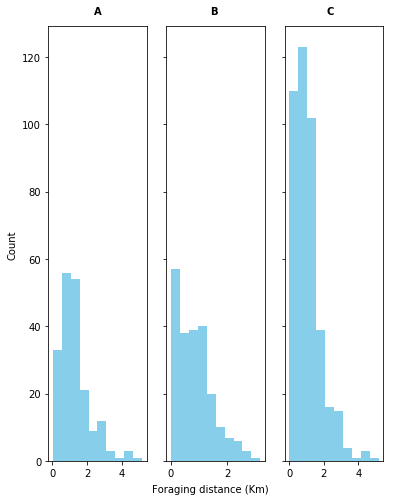

In [13]:
# distributions of foraging distance
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(1, 3, sharex=False, sharey=True, figsize=(6, 8))
ax[0].hist(rural_dist, color="skyblue", density=False)
ax[1].hist(urban_dist, color="skyblue", density=False)
ax[2].hist(all_dist, color = "skyblue", density=False)

fig.text(0.5, 0.07, 'Foraging distance (Km)', ha='center')
fig.text(0.03, 0.5, 'Count', va='center', rotation='vertical')
fig.text(0.23, 0.9, 'A', fontweight='bold')
fig.text(0.50, 0.9, 'B', fontweight='bold')
fig.text(0.77, 0.9, 'C', fontweight='bold')

# Save the full figure
save_path = "../Results/Plots/DistributionHist.pdf"
fig.savefig(save_path)

/home/joe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


<Figure size 432x288 with 0 Axes>

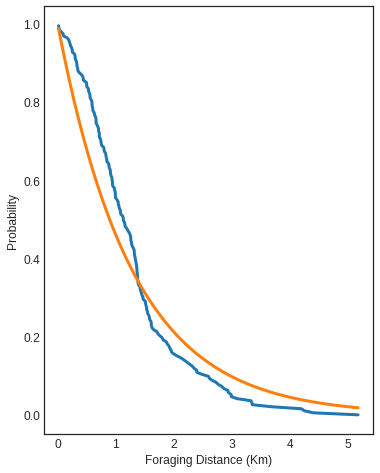

<Figure size 432x288 with 0 Axes>

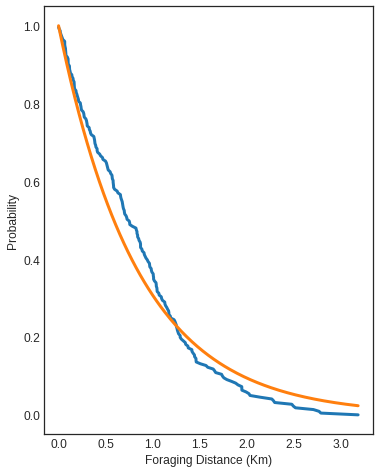

<Figure size 432x288 with 0 Axes>

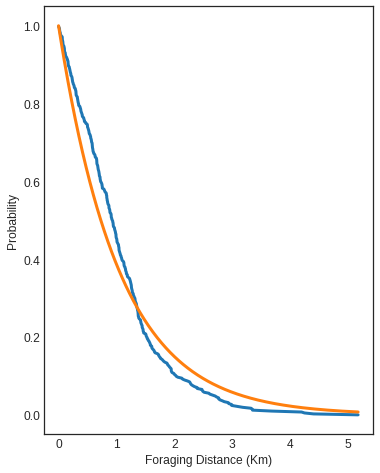

In [8]:
# Exponential [Can be fit analytically but will do numerically for continuity]
# rural
plt.style.use("seaborn-white")
startest = [1.1]
bounds = ((0, None),)
args = (ll_exp, startest, rural_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
rural_exp_model = minimize(*args, **kwargs)
rural_exp_aic = aic_eq(-rural_exp_model.fun, rural_exp_model.x)
rural_exp_plot = predict_fig(rural_dist,
                         rural_exp_model.x,
                         exp_eq)
# add stats to dictionary
model_dict = {"RURAL" : {"Exponential": rural_exp_model}}
df.iloc[0, 0] = "Agri-Rural"
df.iloc[0, 1] = "Exponential"
df.iloc[0, 2] = -rural_exp_model.fun
df.iloc[0, 3] = aic_eq(-rural_exp_model.fun, rural_exp_model.x)

plt.tick_params(labelsize=12)

# urban
startest = [1.1]
bounds = ((0, None),)
args = (ll_exp, startest, urban_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
urban_exp_model = minimize(*args, **kwargs)
urban_exp_aic = aic_eq(-urban_exp_model.fun, urban_exp_model.x)
urban_exp_plot = predict_fig(urban_dist,
                         urban_exp_model.x,
                         exp_eq)
# add stats to dictionary
model_dict["URBAN"] = {"Exponential": urban_exp_model}
df.iloc[1, 0] = "Urban"
df.iloc[1, 1] = "Exponential"
df.iloc[1, 2] = -urban_exp_model.fun
df.iloc[1, 3] = aic_eq(-urban_exp_model.fun, urban_exp_model.x)
plt.tick_params(labelsize=12)

# combined
startest = [1.1]
bounds = ((0, None),)
args = (ll_exp, startest, all_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
all_exp_model = minimize(*args, **kwargs)
all_exp_aic = aic_eq(-all_exp_model.fun, all_exp_model.x)
all_exp_plot = predict_fig(all_dist,
                         all_exp_model.x,
                         exp_eq)
# add stats to dictionary
model_dict["COMBINED"] = {"Exponential": all_exp_model}
df.iloc[2, 0] = "Combined"
df.iloc[2, 1] = "Exponential"
df.iloc[2, 2] = -all_exp_model.fun
df.iloc[2, 3] = aic_eq(-all_exp_model.fun, all_exp_model.x)
plt.tick_params(labelsize=12)

<Figure size 432x288 with 0 Axes>

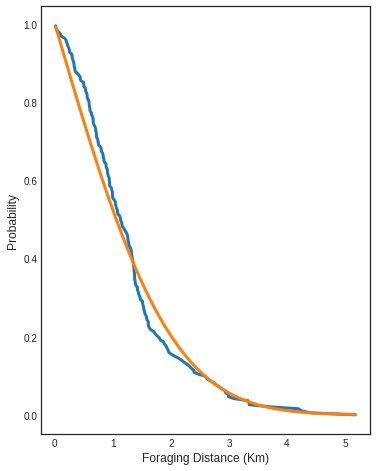

<Figure size 432x288 with 0 Axes>

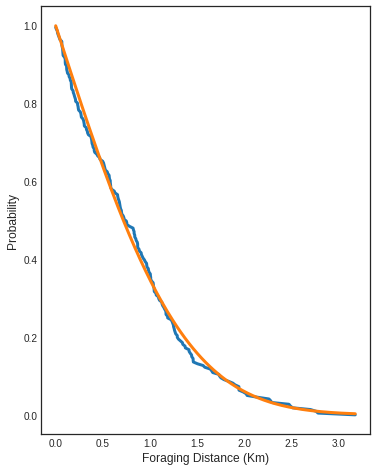

<Figure size 432x288 with 0 Axes>

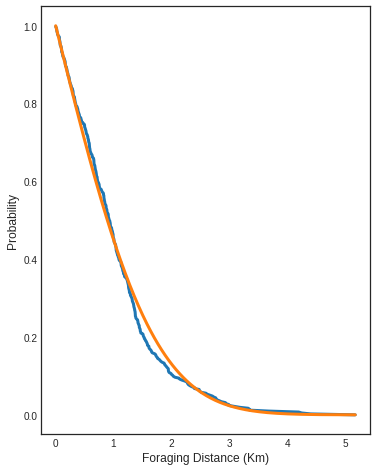

In [9]:
# Half-normal
# rural
startest = [1.1]
bounds = ((0, None),)
args = (ll_halfnorm, startest, rural_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
rural_hn_model = minimize(*args, **kwargs)
rural_hn_aic = aic_eq(-rural_hn_model.fun, rural_hn_model.x)
rural_hn_plot = predict_fig(rural_dist,
                         rural_hn_model.x,
                         halfnorm_eq)
# add stats to dictionary
model_dict["RURAL"]["Half-normal"] = rural_hn_model
df.iloc[3, 0] = "Agri-Rural"
df.iloc[3, 1] = "Half-normal"
df.iloc[3, 2] = -rural_hn_model.fun
df.iloc[3, 3] = aic_eq(-rural_hn_model.fun, rural_hn_model.x)

# urban
startest = [0.8]
bounds = ((0, None),)
args = (ll_halfnorm, startest, urban_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
urban_hn_model = minimize(*args, **kwargs)
urban_hn_aic = aic_eq(-urban_hn_model.fun, urban_hn_model.x)
urban_hn_plot = predict_fig(urban_dist,
                         urban_hn_model.x,
                         halfnorm_eq)
# add stats to dictionary
model_dict["URBAN"]["Half-normal"] = urban_hn_model
df.iloc[4, 0] = "Urban"
df.iloc[4, 1] = "Half-normal"
df.iloc[4, 2] = -urban_hn_model.fun
df.iloc[4, 3] = aic_eq(-urban_hn_model.fun, urban_hn_model.x)

# combined
startest = [0.8]
bounds = ((0, None),)
args = (ll_halfnorm, startest, all_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
all_hn_model = minimize(*args, **kwargs)
all_hn_aic = aic_eq(-all_hn_model.fun, all_hn_model.x)
all_hn_plot = predict_fig(all_dist,
                         all_hn_model.x,
                         halfnorm_eq)
# add stats to dictionary
model_dict["COMBINED"]["Half-normal"] = all_hn_model
df.iloc[5, 0] = "Combined"
df.iloc[5, 1] = "Half-normal"
df.iloc[5, 2] = -all_hn_model.fun
df.iloc[5, 3] = aic_eq(-all_hn_model.fun, all_hn_model.x)

[-0.02965264  0.88400779]
[-0.60430123  1.17541414]
[-0.33641222  1.08810811]


<Figure size 432x288 with 0 Axes>

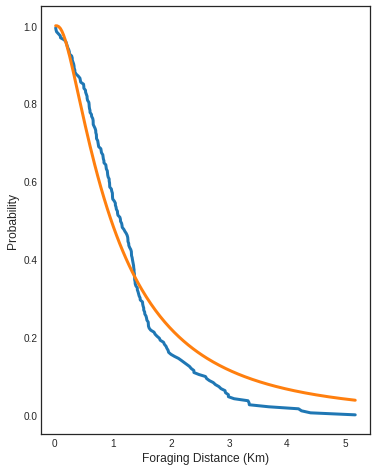

<Figure size 432x288 with 0 Axes>

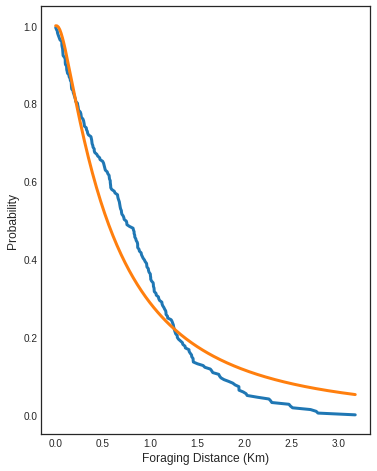

<Figure size 432x288 with 0 Axes>

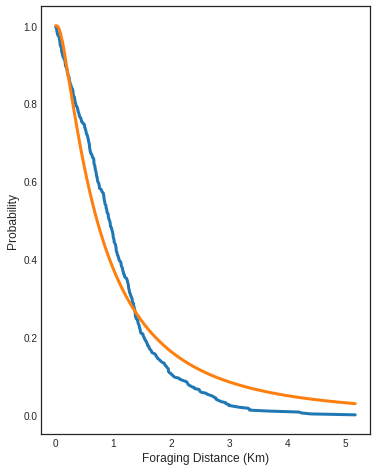

In [10]:
# lognormal
# rural
startest = [0.08 , 0.46]
bounds = ((-1, None),) * len(startest)
args = (ll_lognorm, startest, rural_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
rural_ln_model = minimize(*args, **kwargs)
print(rural_ln_model.x)
rural_ln_aic = aic_eq(-rural_ln_model.fun, rural_ln_model.x)
rural_ln_plot = predict_fig(rural_dist,
                         rural_ln_model.x,
                         lognorm_eq)
# add stats to dictionary
model_dict["RURAL"]["Lognormal"] = rural_ln_model
df.iloc[6, 0] = "Agri-Rural"
df.iloc[6, 1] = "Lognormal"
df.iloc[6, 2] = -rural_ln_model.fun
df.iloc[6, 3] = aic_eq(-rural_ln_model.fun, rural_ln_model.x)

# urban
startest = [0, 0.93]
bounds = ((-1, None),)*len(startest)
args = (ll_lognorm, startest, urban_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
urban_ln_model = minimize(*args, **kwargs)
print(urban_ln_model.x)
urban_ln_aic = aic_eq(-urban_ln_model.fun, urban_ln_model.x)
urban_ln_plot = predict_fig(urban_dist,
                         urban_ln_model.x,
                         lognorm_eq)
# add stats to dictionary
model_dict["URBAN"]["Lognormal"] = urban_ln_model
df.iloc[7, 0] = "Urban"
df.iloc[7, 1] = "Lognormal"
df.iloc[7, 2] = -urban_ln_model.fun
df.iloc[7, 3] = aic_eq(-urban_ln_model.fun, urban_ln_model.x)

# all
startest = [0, 0.93]
bounds = ((-1, None),)*len(startest)
args = (ll_lognorm, startest, all_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
all_ln_model = minimize(*args, **kwargs)
print(all_ln_model.x)
all_ln_aic = aic_eq(-all_ln_model.fun, all_ln_model.x)
all_ln_plot = predict_fig(all_dist,
                         all_ln_model.x,
                         lognorm_eq)
# add stats to dictionary
model_dict["COMBINED"]["Lognormal"] = all_ln_model
df.iloc[8, 0] = "Combined"
df.iloc[8, 1] = "Lognormal"
df.iloc[8, 2] = -all_ln_model.fun
df.iloc[8, 3] = aic_eq(-all_ln_model.fun, all_ln_model.x)

/home/joe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/home/joe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
/home/joe/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in double_scalars


<Figure size 432x288 with 0 Axes>

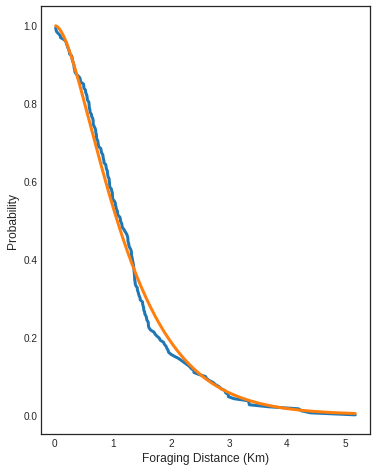

<Figure size 432x288 with 0 Axes>

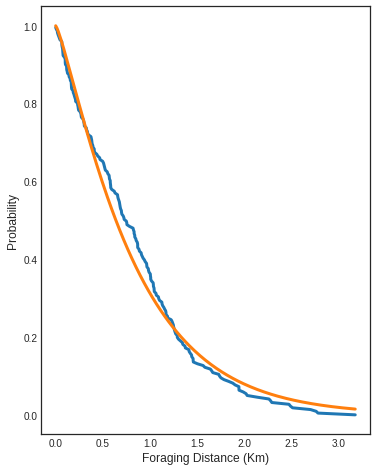

<Figure size 432x288 with 0 Axes>

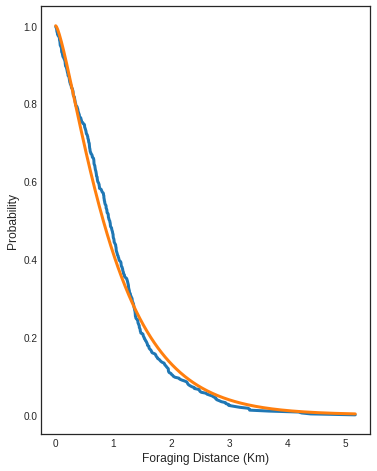

In [11]:
# Gamma
# rural
startest = [1.1, 0.1]
bounds = ((0, None),) * len(startest)
args = (ll_gamma, startest, rural_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
rural_gamma_model = minimize(*args, **kwargs)
rural_gamma_aic = aic_eq(-rural_gamma_model.fun, rural_gamma_model.x)
rural_gamma_plot = predict_fig(rural_dist,
                               rural_gamma_model.x,
                               gamma_eq)
# add stats to dictionary
model_dict["RURAL"]["Gamma"] = rural_gamma_model
df.iloc[9, 0] = "Agri-Rural"
df.iloc[9, 1] = "Gamma"
df.iloc[9, 2] = -rural_gamma_model.fun
df.iloc[9, 3] = aic_eq(-rural_gamma_model.fun, rural_gamma_model.x)

# urban
startest = [1.1, 0.1]
bounds = ((0, None),)*len(startest)
args = (ll_gamma, startest, urban_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
urban_gamma_model = minimize(*args, **kwargs)
urban_gamma_aic = aic_eq(-urban_gamma_model.fun, urban_gamma_model.x)
urban_gamma_plot = predict_fig(urban_dist,
                               urban_gamma_model.x,
                               gamma_eq)
# add stats to dictionary
model_dict["URBAN"]["Gamma"] = urban_gamma_model
df.iloc[10, 0] = "Urban"
df.iloc[10, 1] = "Gamma"
df.iloc[10, 2] = -urban_gamma_model.fun
df.iloc[10, 3] = aic_eq(-urban_gamma_model.fun, urban_gamma_model.x)

# all
startest = [1.1, 0.1]
bounds = ((0, None),)*len(startest)
args = (ll_gamma, startest, all_dist)
kwargs = {"method" : "SLSQP", "bounds" : bounds}
all_gamma_model = minimize(*args, **kwargs)
all_gamma_aic = aic_eq(-all_gamma_model.fun, all_gamma_model.x)
all_gamma_plot = predict_fig(all_dist,
                               all_gamma_model.x,
                               gamma_eq)
# add stats to dictionary
model_dict["COMBINED"]["Gamma"] = all_gamma_model
df.iloc[11, 0] = "Combined"
df.iloc[11, 1] = "Gamma"
df.iloc[11, 2] = -all_gamma_model.fun
df.iloc[11, 3] = aic_eq(-all_gamma_model.fun, all_gamma_model.x)

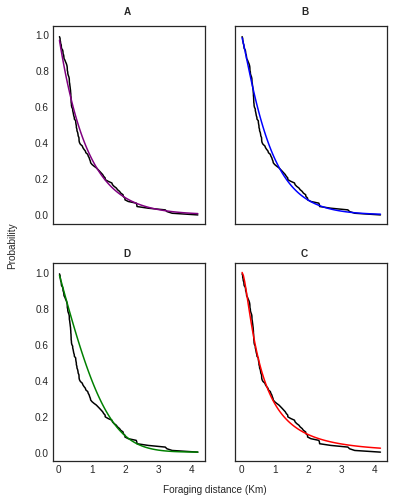

In [114]:
# Make plots # CHANGE SAVE NAME WHEN CHANGING DATA SOURCE!
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 8))

# top left = exponential
df2 = predict(rural_dist, rural_exp_model.x, exp_eq)
l1 = ax[0, 0].plot(df2["SortedData"],
              df2["Probability"],
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = ax[0, 0].plot(df2["Lengths"],
              df2["Prediction"],
              linewidth=1.5,
              color="purple")

# top right = gamma
df2 = predict(rural_dist, rural_gamma_model.x, gamma_eq)
l1 = ax[0, 1].plot(df2["SortedData"],
              df2["Probability"],
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = ax[0, 1].plot(df2["Lengths"],
              df2["Prediction"],
              linewidth=1.5,
              color="blue")

# top left = half-normal
df2 = predict(rural_dist, rural_hn_model.x, halfnorm_eq)
l1 = ax[1, 0].plot(df2["SortedData"],
              df2["Probability"],
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = ax[1, 0].plot(df2["Lengths"],
              df2["Prediction"],
              linewidth=1.5,
              color="green")

# top left = lognormal
df2 = predict(rural_dist, rural_ln_model.x, lognorm_eq)
l1 = ax[1, 1].plot(df2["SortedData"],
              df2["Probability"],
              label = "Distance",
              linewidth=1.5,
              color="black")
l2 = ax[1, 1].plot(df2["Lengths"],
              df2["Prediction"],
              linewidth=1.5,
              color="red")

fig.text(0.5, 0.07, 'Foraging distance (Km)', ha='center')
fig.text(0.02, 0.5, 'Probability', va='center', rotation='vertical')
fig.text(0.29, 0.9, 'A', fontweight='bold')
fig.text(0.7, 0.9, 'B', fontweight='bold')
fig.text(0.29, 0.48, 'D', fontweight='bold')
fig.text(0.7, 0.48, 'C', fontweight='bold')

# Save the full figure
save_path = "../Results/Plots/RuralDistributionFit_1km.pdf"
fig.savefig(save_path)

In [116]:
# results
pd.options.mode.chained_assignment = None # remove set with copy warning

# split data into seperate tables by location
rural_df = df[df["Location"] == "Agri-Rural"]
urban_df = df[df["Location"] == "Urban"]
all_df = df[df["Location"] == "Combined"]

# calulcate weighted AIC
urban_df["AIC"] = urban_df["AIC"].astype("float")
urban_df["Realtive_AICw"] = np.exp(-0.5*(urban_df["AIC"] - min(urban_df["AIC"])))
urban_df["AICw"] = urban_df["Realtive_AICw"]/sum(urban_df["Realtive_AICw"])

# same for rural
rural_df["AIC"] = rural_df["AIC"].astype("float")
rural_df["Realtive_AICw"] = np.exp(-0.5*(rural_df["AIC"] - min(rural_df["AIC"])))
rural_df["AICw"] = rural_df["Realtive_AICw"]/sum(rural_df["Realtive_AICw"])

# same for combined
all_df["AIC"] = all_df["AIC"].astype("float")
all_df["Realtive_AICw"] = np.exp(-0.5*(all_df["AIC"] - min(all_df["AIC"])))
all_df["AICw"] = all_df["Realtive_AICw"]/sum(all_df["Realtive_AICw"])

# remove columns for display
rural_df.drop(["Location", "Realtive_AICw"], axis=1, inplace=True)
rural_df = rural_df.sort_values(["AIC"])
urban_df.drop(["Location", "Realtive_AICw"], axis=1, inplace=True)
urban_df = urban_df.sort_values(["AIC"])
all_df.drop(["Location", "Realtive_AICw"], axis=1, inplace=True)
all_df = all_df.sort_values(["AIC"])

# save table as latex file
with open('../Results/LatexTables/rural_distfit_1km.tex','w') as tf:
    rural_1k_caption = ""
    tf.write(rural_df.to_latex(index=False))
with open('../Results/LatexTables/urban_distfit_1km.tex','w') as tf:
    tf.write(urban_df.to_latex(index=False))
with open('../Results/LatexTables/combined_distfit_1km.tex','w') as tf:
    tf.write(all_df.to_latex(index=False))

In [117]:
# calculate how much better the best model is from the next best model
print(rural_df)
best_waic = rural_df.iloc[0, -1]
best2_waic = rural_df.iloc[1, -1]

print(best_waic/best2_waic)
print(best_waic, best2_waic)

print(urban_df)
best_waic = urban_df.iloc[0, -1]
best2_waic = urban_df.iloc[1, -1]

print(best_waic/best2_waic)
print(best_waic, best2_waic)

print(all_df)
best_waic = all_df.iloc[0, -1]
best2_waic = all_df.iloc[1, -1]

print(best_waic/best2_waic)
print(best_waic, best2_waic)

  Distribution      MLE         AIC      AICw
9        Gamma -88.4953  180.990608  0.444697
0  Exponential -89.8349  181.669702  0.316665
6    Lognormal -89.1227  182.245326  0.237468
3  Half-normal -95.4361  192.872228  0.001170
1.4043114260641159
0.44469684122500247 0.316665401257441
   Distribution      MLE        AIC      AICw
1   Exponential  -29.446  60.891934  0.699804
10        Gamma -29.3618  62.723513  0.280062
4   Half-normal -32.9953  67.990502  0.020116
7     Lognormal  -39.024  82.048053  0.000018
2.4987475042013734
0.6998041768102984 0.2800619813060957
   Distribution      MLE         AIC          AICw
2   Exponential -124.347  250.693054  7.134821e-01
11        Gamma -124.259  252.517781  2.865158e-01
8     Lognormal -136.396  276.792210  1.534700e-06
5   Half-normal -138.436  278.871001  5.427747e-07
2.490201262880391
0.7134820894242079 0.2865158331013495
